# ESP32 Air Mouse – Gesture Training Notebook

This notebook helps you train a simple gesture classifier from raw IMU logs collected via the desktop app.

What you’ll do:
- Load CSV logs (columns: timestamp, ax, ay, az, gx, gy, gz, label)
- Window the data (default: 1.0 s windows at ~100 Hz, 50% overlap)
- Extract simple, robust features (stats + band energy)
- Train and evaluate:
  - Baseline: Random Forest
  - Optional: Small TensorFlow dense classifier
- Export: TFLite int8 model and a C array header for firmware

Tips:
- Keep gestures short (1–2 s) and clearly labeled.
- Capture at least 50–100 windows per class.
- Balance classes or use class weights.


In [33]:
# If running for the first time, you may need these. They’ll only install if missing.
import sys, subprocess

def ensure(pkg, import_name=None):
    import importlib
    try:
        importlib.import_module(import_name or pkg)
    except ImportError:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# Core
ensure("numpy")
ensure("pandas")
ensure("scikit-learn", "sklearn")
ensure("scipy")
ensure("matplotlib")
# Extra classical ML libs (optional)
try:
    ensure("xgboost")
except Exception as e:
    print("xgboost install skipped/error:", e)
try:
    ensure("lightgbm")
except Exception as e:
    print("lightgbm install skipped/error:", e)
# Optional deep learning (skip if you only want classical models)
try:
    import tensorflow as tf  # noqa: F401
except Exception:
    print("TensorFlow not available; will skip TF model unless installed.")


In [34]:
# Configuration parameters for windowing & modeling
# Adjust these to match your data collection rate and desired window size.
EXPECTED_HZ = 100.0        # Approx IMU sample rate (Hz). Will be auto-adjusted if inference disagrees.
WINDOW_SECONDS = 1.0       # Nominal window length in seconds
WINDOW_OVERLAP = 0.5       # Fractional overlap between consecutive windows (0.0–0.9)
RANDOM_STATE = 42          # Reproducible seed for splits/models

# If your logs are very short or sparse, you can reduce WINDOW_SECONDS (e.g., 0.3)
# If you have lots of data and want more augmentation, increase overlap (e.g., 0.75)
print(f"Config: EXPECTED_HZ={EXPECTED_HZ}, WINDOW_SECONDS={WINDOW_SECONDS}, WINDOW_OVERLAP={WINDOW_OVERLAP}, RANDOM_STATE={RANDOM_STATE}")

Config: EXPECTED_HZ=100.0, WINDOW_SECONDS=1.0, WINDOW_OVERLAP=0.5, RANDOM_STATE=42


In [35]:
import os, glob, math, json, time
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import welch
import matplotlib.pyplot as plt

# Robust data directory discovery (tries multiple common locations)
CANDIDATE_DIRS = [
    Path("..") / "desktop_qt" / "ml_logs",
    Path("..") / "desktop_app" / "ml_logs",
    Path("..") / "ml_logs",
]
found = []
for d in CANDIDATE_DIRS:
    files = sorted(glob.glob(str(d / "*.csv")))
    print(f"Scan: {d.resolve()} -> {len(files)} files")
    found.extend(files)

# Default: use ALL discovered CSVs
PIN_FILENAME = None  # set to a single filename (e.g., 'flick_left_20251109_101010.csv') to load only that one

if PIN_FILENAME:
    candidates = [p for p in found if p.endswith(PIN_FILENAME)]
    if not candidates:
        raise FileNotFoundError(f"Pinned CSV '{PIN_FILENAME}' not found in: {[str(p) for p in CANDIDATE_DIRS]}")
    all_files = candidates
else:
    all_files = found

print(f"Total discovered CSV files: {len(all_files)}")
assert all_files, "No CSV log files found in any ml_logs directory. Check the path or move/symlink your logs."
print("Files loaded:", [os.path.basename(p) for p in all_files])

frames = []
required_cols = {"timestamp","ax","ay","az","gx","gy","gz","label"}
alt_time_cols = ["time","ts","millis","timestamp_ms","time_ms","t_ms"]
for f in all_files:
    # Robust CSV read with fallback delimiter sniffing
    try:
        df = pd.read_csv(f)
    except Exception:
        df = pd.read_csv(f, sep=None, engine="python")
    cols = set(df.columns)
    # Timestamp fallback
    if "timestamp" not in cols:
        alt = next((c for c in alt_time_cols if c in cols), None)
        if alt:
            print(f"[Info] Using '{alt}' as timestamp for {os.path.basename(f)}")
            df.rename(columns={alt:"timestamp"}, inplace=True)
    # Coerce numeric timestamp
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")
    # Label fallback from filename when missing
    if "label" not in df.columns:
        inferred_label = Path(f).stem.split("_")[0]
        print(f"[Info] No 'label' column in {os.path.basename(f)} -> using '{inferred_label}' from filename")
        df["label"] = inferred_label
    # Required sensor columns coercion
    for c in ["ax","ay","az","gx","gy","gz"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        else:
            raise ValueError(f"Missing required column '{c}' in {f}")
    before = len(df)
    df = df.dropna(subset=["timestamp","ax","ay","az","gx","gy","gz","label"]).copy()
    dropped = before - len(df)
    if dropped:
        print(f"[Info] Dropped {dropped} rows with NaNs in required fields from {os.path.basename(f)}")
    df['source_file'] = os.path.basename(f)
    frames.append(df)

raw = pd.concat(frames, ignore_index=True)
print("Loaded rows:", len(raw))
print("Columns:", list(raw.columns))
print("Per-label counts:\n", raw['label'].value_counts())

Scan: D:\Code\Arduino\ESP32\ESP32_MPU6050_Air_Mouse\desktop_qt\ml_logs -> 2 files
Scan: D:\Code\Arduino\ESP32\ESP32_MPU6050_Air_Mouse\desktop_app\ml_logs -> 0 files
Scan: D:\Code\Arduino\ESP32\ESP32_MPU6050_Air_Mouse\ml_logs -> 0 files
Total discovered CSV files: 2
Files loaded: ['flick_left_20251109_031457_8d5c3d8d_1.csv', 'flick_right_20251109_032720_3e1a6a5a_1.csv']
[Info] Using 'timestamp_ms' as timestamp for flick_left_20251109_031457_8d5c3d8d_1.csv
[Info] Using 'timestamp_ms' as timestamp for flick_right_20251109_032720_3e1a6a5a_1.csv
Loaded rows: 608
Columns: ['timestamp', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'label', 'segment_id', 'sample_index', 'source_file']
Per-label counts:
 label
flick_right    433
flick_left     175
Name: count, dtype: int64


In [36]:
# CSV diagnostics (run after the data loading cell)
from pathlib import Path

print("\n=== CSV diagnostics ===")
print("Candidate directories:")
for d in CANDIDATE_DIRS:
    try:
        print(" -", d.resolve(), "exists=", d.exists())
    except Exception:
        print(" -", d, "(resolve failed)")

# Pick a target file: PIN_FILENAME if set, else first available
if PIN_FILENAME:
    targets = [p for p in found if p.endswith(PIN_FILENAME)]
else:
    targets = found[:1]

if not targets:
    print("No CSVs found to inspect.")
else:
    p = Path(targets[0])
    print("Inspecting:", p)
    try:
        df0 = pd.read_csv(p)
        print("Shape:", df0.shape)
        print("Columns:", list(df0.columns))
        print("Dtypes:\n", df0.dtypes)
        print("Head:\n", df0.head())
        if 'label' in df0.columns:
            print("Labels unique:", df0['label'].unique())
        # Try to interpret time
        ts_col = 'timestamp' if 'timestamp' in df0.columns else (next((c for c in ['time','ts','millis'] if c in df0.columns), None))
        if ts_col:
            ts_num = pd.to_numeric(df0[ts_col], errors='coerce')
            valid = ts_num.dropna()
            if len(valid) > 1:
                deltas = np.diff(np.sort(valid.to_numpy()))
                if len(deltas):
                    print("Median dt:", np.median(deltas), "Max dt:", np.max(deltas))
            print("Timestamp sample:", df0[ts_col].head().tolist())
        else:
            print("No timestamp-like column found (timestamp/time/ts/millis)")
    except Exception as e:
        print("Error reading CSV:", e)



=== CSV diagnostics ===
Candidate directories:
 - D:\Code\Arduino\ESP32\ESP32_MPU6050_Air_Mouse\desktop_qt\ml_logs exists= True
 - D:\Code\Arduino\ESP32\ESP32_MPU6050_Air_Mouse\desktop_app\ml_logs exists= False
 - D:\Code\Arduino\ESP32\ESP32_MPU6050_Air_Mouse\ml_logs exists= False
Inspecting: ..\desktop_qt\ml_logs\flick_left_20251109_031457_8d5c3d8d_1.csv
Shape: (175, 10)
Columns: ['timestamp_ms', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'label', 'segment_id', 'sample_index']
Dtypes:
 timestamp_ms     int64
ax               int64
ay               int64
az               int64
gx               int64
gy               int64
gz               int64
label           object
segment_id      object
sample_index     int64
dtype: object
Head:
     timestamp_ms  ax  ay    az  gx  gy  gz       label segment_id  \
0  1762636495403 -58  -5  1018  28   4  10  flick_left   8d5c3d8d   
1  1762636495428 -64   0  1018  14  10  -3  flick_left   8d5c3d8d   
2  1762636495433 -55  -2  1018   8 -15  34  flick_left  

In [37]:
# Windowing helper with adaptive sampling and diagnostics
# Determine effective sampling rate from timestamps
if raw.empty:
    raise ValueError("Raw dataframe is empty – no data loaded. Check DATA_DIR and CSV logs.")

# Infer time unit (ms vs s) using median delta; fallback if insufficient data
sample_deltas = []
for lbl, grp in raw.groupby('label'):
    ts_arr = grp['timestamp'].to_numpy()
    if len(ts_arr) > 1:
        d = np.diff(np.sort(ts_arr))
        # Filter obviously bad (negative) deltas
        d = d[d > 0]
        if len(d):
            sample_deltas.extend(d.tolist())

if not sample_deltas:
    # Fallback: assume user intended EXPECTED_HZ; fabricate median_dt accordingly
    print(f"[Fallback] Not enough timestamp gaps to infer sampling rate (need >=2 samples in at least one label). Using EXPECTED_HZ={EXPECTED_HZ}.")
    # Assume milliseconds scale if EXPECTED_HZ > 5
    if EXPECTED_HZ > 5:
        median_dt = 1000.0 / EXPECTED_HZ  # pretend ms intervals
        effective_hz = EXPECTED_HZ
    else:
        median_dt = 1.0 / EXPECTED_HZ
        effective_hz = EXPECTED_HZ
else:
    median_dt = np.median(sample_deltas)
    # Original heuristic: treat >5 as ms; refine with additional guard below
    if median_dt > 5:  # treat as ms
        effective_hz = 1000.0 / median_dt
    else:  # seconds
        effective_hz = 1.0 / median_dt
print(f"Inferred/used sampling interval median_dt={median_dt:.3f}; effective_hz≈{effective_hz:.2f}")

# Allow override of EXPECTED_HZ if large deviation (>20%) and we had real inference
if sample_deltas and abs(effective_hz - EXPECTED_HZ) / max(EXPECTED_HZ,1e-6) > 0.2:
    print(f"Adjusting EXPECTED_HZ from {EXPECTED_HZ} to inferred {effective_hz:.2f}")
    EXPECTED_HZ = effective_hz

# Heuristic scale correction: if effective_hz implausibly low (<5 Hz) yet median_dt looks like small integer (2..50), assume milliseconds misinterpreted
if sample_deltas and effective_hz < 5 and 2 <= median_dt <= 50:
    print(f"[Heuristic] median_dt={median_dt:.3f} likely milliseconds (not seconds); reinterpreting units as ms.")
    effective_hz = 1000.0 / median_dt
    EXPECTED_HZ = effective_hz
    print(f"[Heuristic] Adjusted EXPECTED_HZ to {EXPECTED_HZ:.2f} Hz")

SAMPLES_PER_WINDOW = int(WINDOW_SECONDS * EXPECTED_HZ)
if SAMPLES_PER_WINDOW < 5:
    # Attempt auto expansion of window length instead of hard failure
    min_needed = 5
    needed_sec = min_needed / max(EXPECTED_HZ, 1e-6)
    if needed_sec <= WINDOW_SECONDS * 4:  # cap expansion factor
        print(f"[Auto] Expanding WINDOW_SECONDS from {WINDOW_SECONDS:.3f} to {needed_sec:.3f} to reach >=5 samples.")
        WINDOW_SECONDS = needed_sec
        SAMPLES_PER_WINDOW = min_needed
    else:
        # Final fallback: force ms interpretation if not already applied
        if effective_hz < 5 and 2 <= median_dt <= 1000:
            print("[Final Attempt] Forcing millisecond interpretation.")
            effective_hz = 1000.0 / median_dt
            EXPECTED_HZ = effective_hz
            SAMPLES_PER_WINDOW = int(WINDOW_SECONDS * EXPECTED_HZ)
        if SAMPLES_PER_WINDOW < 5:
            raise ValueError(f"Window length too short ({SAMPLES_PER_WINDOW} samples even after adjustments). Increase WINDOW_SECONDS or collect higher-rate data.")

STEP = max(1, int(SAMPLES_PER_WINDOW * (1 - WINDOW_OVERLAP)))
print(f"Samples/window: {SAMPLES_PER_WINDOW}, step: {STEP}")

# Diagnostic: per-label sample counts
label_counts = raw['label'].value_counts().to_dict()
print("Per-label sample counts:", label_counts)
min_label_samples = min(label_counts.values())
if min_label_samples < SAMPLES_PER_WINDOW:
    print(f"WARNING: Smallest label has only {min_label_samples} samples (< {SAMPLES_PER_WINDOW}).")
    if min_label_samples >= 3:
        adjusted_samples = max(3, int(min_label_samples * 0.9))
        if adjusted_samples < SAMPLES_PER_WINDOW:
            print(f"Auto-adjusting SAMPLES_PER_WINDOW from {SAMPLES_PER_WINDOW} to {adjusted_samples}.")
            SAMPLES_PER_WINDOW = adjusted_samples
            WINDOW_SECONDS = SAMPLES_PER_WINDOW / EXPECTED_HZ
            STEP = max(1, int(SAMPLES_PER_WINDOW * (1 - WINDOW_OVERLAP)))
            print(f"New window config: WINDOW_SECONDS={WINDOW_SECONDS:.3f}, samples={SAMPLES_PER_WINDOW}, step={STEP}")
    else:
        print("Too few samples (<3) for any window; collect more data.")

# Force a smaller window if needed for tiny logs (simple guard)
if SAMPLES_PER_WINDOW > 20:
    SAMPLES_PER_WINDOW = max(5, min(SAMPLES_PER_WINDOW, 20))
    WINDOW_SECONDS = SAMPLES_PER_WINDOW / EXPECTED_HZ
    STEP = max(1, int(SAMPLES_PER_WINDOW * (1 - WINDOW_OVERLAP)))
    print(f"[Guard] Using smaller window: WINDOW_SECONDS={WINDOW_SECONDS:.3f}, samples={SAMPLES_PER_WINDOW}, step={STEP}")

ANOMALY_MULT = 5.0  # relaxed anomaly filter

windows = []
labels = []

# If chronological fallback needed (e.g., single label), enable when only one label present
chronological_mode = (len(label_counts) == 1)
if chronological_mode:
    print("[Mode] Single label detected; using chronological sliding windows.")
    g = raw.sort_values('timestamp')
    arr = g[['ax','ay','az','gx','gy','gz']].to_numpy()
    ts = g['timestamp'].to_numpy()
    if len(arr) >= SAMPLES_PER_WINDOW:
        for start in range(0, len(arr) - SAMPLES_PER_WINDOW + 1, STEP):
            segment = arr[start:start+SAMPLES_PER_WINDOW]
            tseg = ts[start:start+SAMPLES_PER_WINDOW]
            deltas = np.diff(tseg)
            if len(deltas) and np.max(deltas) > ANOMALY_MULT * max(np.median(deltas),1e-6):
                continue
            windows.append(segment)
            labels.append(g['label'].iloc[start])
else:
    for label, group in raw.groupby('label'):
        g = group.sort_values('timestamp')
        arr = g[['ax','ay','az','gx','gy','gz']].to_numpy()
        ts = g['timestamp'].to_numpy()
        if len(arr) < SAMPLES_PER_WINDOW:
            continue
        for start in range(0, len(arr) - SAMPLES_PER_WINDOW + 1, STEP):
            segment = arr[start:start+SAMPLES_PER_WINDOW]
            tseg = ts[start:start+SAMPLES_PER_WINDOW]
            deltas = np.diff(tseg)
            if len(deltas) and np.max(deltas) > ANOMALY_MULT * max(np.median(deltas),1e-6):
                continue
            windows.append(segment)
            labels.append(label)

print(f"Created {len(windows)} windows total")
unique_labels = sorted(set(labels))
if not windows:
    print("No windows created. Collect more samples OR reduce WINDOW_SECONDS to <0.3 OR increase overlap.")
    # Provide empty arrays for downstream graceful handling
    y = np.array([])
    X = np.empty((0, SAMPLES_PER_WINDOW, 6))
else:
    label_to_idx = {l:i for i,l in enumerate(unique_labels)}
    y = np.array([label_to_idx[l] for l in labels])
    X = np.array(windows)
    print("Window tensor shape:", X.shape)
    print("Labels:", unique_labels)


Inferred/used sampling interval median_dt=5.000; effective_hz≈0.20
Adjusting EXPECTED_HZ from 100.0 to inferred 0.20
[Heuristic] median_dt=5.000 likely milliseconds (not seconds); reinterpreting units as ms.
[Heuristic] Adjusted EXPECTED_HZ to 200.00 Hz
Samples/window: 200, step: 100
Per-label sample counts: {'flick_right': 433, 'flick_left': 175}
Auto-adjusting SAMPLES_PER_WINDOW from 200 to 157.
New window config: WINDOW_SECONDS=0.785, samples=157, step=78
[Guard] Using smaller window: WINDOW_SECONDS=0.100, samples=20, step=10
Created 45 windows total
Window tensor shape: (45, 20, 6)
Labels: ['flick_left', 'flick_right']


In [38]:
# Feature extraction
# We'll compute per-axis statistics + overall magnitude stats + simple band energy via Welch.

FEATURES = []
feature_names = []

if X.shape[0] == 0:
    raise RuntimeError("No windows available for feature extraction – revisit windowing parameters or collect more data.")

for i in range(X.shape[0]):
    segment = X[i]  # (samples, 6)
    ax, ay, az, gx, gy, gz = segment.T
    feats = []
    def add_stats(prefix, data):
        feats.extend([
            np.mean(data),
            np.std(data),
            np.min(data),
            np.max(data),
            np.median(data),
            np.percentile(data, 25),
            np.percentile(data, 75),
        ])
        if i == 0:
            feature_names.extend([
                f"{prefix}_mean", f"{prefix}_std", f"{prefix}_min", f"{prefix}_max",
                f"{prefix}_median", f"{prefix}_p25", f"{prefix}_p75"
            ])

    for prefix, data in [("ax", ax),("ay", ay),("az", az),("gx", gx),("gy", gy),("gz", gz)]:
        add_stats(prefix, data)

    # Magnitudes
    a_mag = np.sqrt(ax*ax + ay*ay + az*az)
    g_mag = np.sqrt(gx*gx + gy*gy + gz*gz)
    add_stats("a_mag", a_mag)
    add_stats("g_mag", g_mag)

    # Simple frequency band energies for accel magnitude
    freqs, psd = welch(a_mag, fs=EXPECTED_HZ, nperseg=min(len(a_mag), 128))
    bands = [(0.5,2),(2,5),(5,10),(10,20)]
    for (lo, hi) in bands:
        mask = (freqs >= lo) & (freqs < hi)
        energy = np.sum(psd[mask])
        feats.append(energy)
        if i == 0:
            feature_names.append(f"a_mag_energy_{lo}_{hi}")

    FEATURES.append(feats)

X_feats = np.array(FEATURES)
print("Feature matrix shape:", X_feats.shape)
if X_feats.shape[0] > 0:
    print("First row sample:", X_feats[0][:10], "...")
print("Total features:", len(feature_names))


Feature matrix shape: (45, 60)
First row sample: [-60.9          3.4190642  -67.         -55.         -61.
 -64.         -58.          -1.35         5.13103303 -14.        ] ...
Total features: 60


In [39]:
# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X_feats, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (33, 60) Test size: (12, 60)


In [40]:
# Baseline model: Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=None, class_weight="balanced", random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=unique_labels))
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


              precision    recall  f1-score   support

  flick_left       1.00      1.00      1.00         2
 flick_right       1.00      1.00      1.00        10

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Confusion matrix:
 [[ 2  0]
 [ 0 10]]


In [41]:
# Advanced models: GradientBoosting, XGBoost, LightGBM, SVM (RBF)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import pandas as pd

advanced_results = []
proba_store = {}

# Reuse RandomForest (rf) already trained; capture its probabilities
if 'rf' in globals():
    try:
        proba_store['RandomForest'] = rf.predict_proba(X_test)
        acc = accuracy_score(y_test, rf.predict(X_test))
        f1 = f1_score(y_test, rf.predict(X_test), average='macro')
        advanced_results.append(['RandomForest', acc, f1])
    except Exception as e:
        print("RF probas unavailable:", e)
else:
    print("RandomForest model not found; skipping its metrics copy.")

# Helper to train, store metrics
def train_and_store(name, estimator):
    try:
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        # Probabilities or decision function
        if hasattr(estimator, 'predict_proba'):
            proba = estimator.predict_proba(X_test)
        elif hasattr(estimator, 'decision_function'):
            dfc = estimator.decision_function(X_test)
            if dfc.ndim == 1:
                dfc = np.vstack([ -dfc, dfc ]).T
            expd = np.exp(dfc - np.max(dfc, axis=1, keepdims=True))
            proba = expd / np.sum(expd, axis=1, keepdims=True)
        else:
            proba = None
        if proba is not None:
            proba_store[name] = proba
        advanced_results.append([name, acc, f1])
        print(f"{name} accuracy={acc:.3f} macroF1={f1:.3f}")
    except Exception as e:
        print(f"{name} training failed: {e}")

# Gradient Boosting
train_and_store('GradientBoosting', GradientBoostingClassifier(random_state=RANDOM_STATE))

# XGBoost
try:
    import xgboost as xgb
    xgb_clf = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE,
        use_label_encoder=False
    )
    train_and_store('XGBoost', xgb_clf)
except Exception as e:
    print("XGBoost unavailable/skipped:", e)

# LightGBM
try:
    import lightgbm as lgb
    lgb_clf = lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        random_state=RANDOM_STATE
    )
    train_and_store('LightGBM', lgb_clf)
except Exception as e:
    print("LightGBM unavailable/skipped:", e)

# SVM (RBF) with scaling
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=2.0, gamma='scale', probability=True, class_weight='balanced', random_state=RANDOM_STATE))
])
train_and_store('SVM-RBF', svm_pipeline)

adv_df = pd.DataFrame(advanced_results, columns=['Model','Accuracy','MacroF1']).sort_values('Accuracy', ascending=False)
print('\nModel performance summary:')
print(adv_df)


GradientBoosting accuracy=0.833 macroF1=0.778
XGBoost accuracy=1.000 macroF1=1.000
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 26, number of negative: 7
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 33, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787879 -> initscore=1.312186
[LightGBM] [Info] Start training from score 1.312186
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves 

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [18:03:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


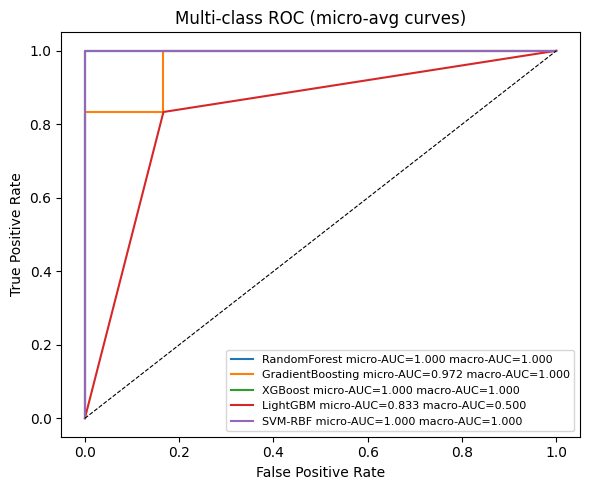

In [42]:
# Multi-class ROC curves (one-vs-rest) for models with probability outputs
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

if 'proba_store' not in globals() or not proba_store:
    print("No probability data available to plot ROC curves.")
else:
    import numpy as np
    # Determine number of classes from probability arrays to avoid stale unique_labels state
    nclass_candidates = [p.shape[1] for p in proba_store.values() if p is not None]
    if not nclass_candidates:
        print("No probability matrices found in proba_store.")
    else:
        n_classes = max(nclass_candidates)
        if n_classes < 2:
            print("ROC requires at least 2 classes; only one class present.")
        else:
            # Build one-vs-rest binarized y_test with n_classes columns (robust even if some classes absent)
            y_arr = np.asarray(y_test)
            Y_test_bin = np.zeros((y_arr.shape[0], n_classes), dtype=int)
            for c in range(n_classes):
                Y_test_bin[:, c] = (y_arr == c).astype(int)

            plt.figure(figsize=(6,5))
            any_plotted = False
            for name, proba in proba_store.items():
                if proba is None:
                    print(f"Skipping {name} ROC (no probabilities available)")
                    continue
                if proba.shape[1] != n_classes:
                    print(f"Skipping {name} ROC (proba shape mismatch: {proba.shape} vs classes={n_classes})")
                    continue
                # Compute per-class AUC, skipping classes with no positive samples in y_test
                aucs = []
                skipped_classes = 0
                for c in range(n_classes):
                    y_true_c = Y_test_bin[:, c]
                    # Need at least one positive and one negative sample for ROC
                    if len(set(y_true_c)) < 2 or y_true_c.sum() == 0 or y_true_c.sum() == len(y_true_c):
                        skipped_classes += 1
                        continue
                    fpr, tpr, _ = roc_curve(y_true_c, proba[:, c])
                    aucs.append(auc(fpr, tpr))
                if not aucs:
                    print(f"Skipping {name} ROC (no valid classes in y_test; skipped {skipped_classes})")
                    continue
                macro_auc = float(np.mean(aucs))
                # Micro-average (guard for degenerate case)
                try:
                    fpr_micro, tpr_micro, _ = roc_curve(Y_test_bin.ravel(), proba.ravel())
                    micro_auc = auc(fpr_micro, tpr_micro)
                    plt.plot(fpr_micro, tpr_micro, label=f"{name} micro-AUC={micro_auc:.3f} macro-AUC={macro_auc:.3f}")
                    any_plotted = True
                except Exception as e:
                    print(f"{name} micro-average ROC skipped: {e}")

            plt.plot([0,1],[0,1],'k--',linewidth=0.8)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Multi-class ROC (micro-avg curves)')
            if any_plotted:
                plt.legend(fontsize=8)
                plt.tight_layout()
                plt.show()
            else:
                print("No valid ROC curves to plot (insufficient class variety in test set).")


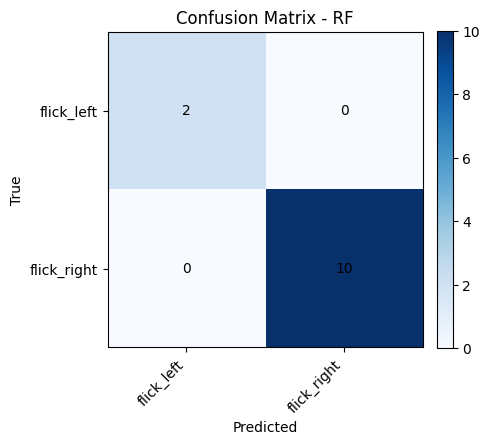

In [43]:
# Plot confusion matrix
def plot_confusion_matrix(cm, labels):
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i,j], ha='center', va='center', color='black')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix - RF')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(confusion_matrix(y_test, y_pred), unique_labels)


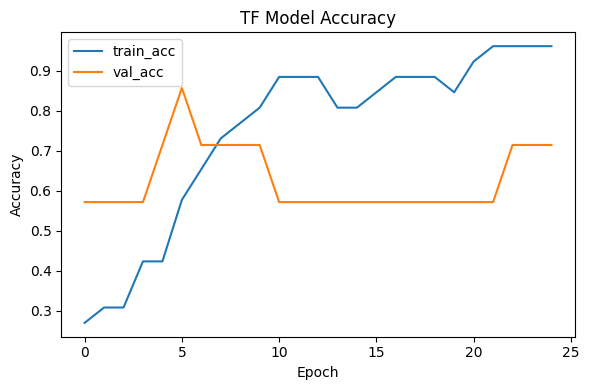

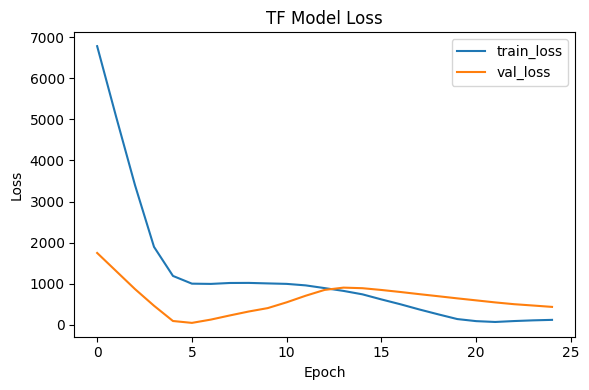

In [44]:
# Accuracy & loss curves for TensorFlow model (if trained)
import matplotlib.pyplot as plt
if 'history' in globals():
    hist = history.history
    if 'accuracy' in hist:
        plt.figure(figsize=(6,4))
        plt.plot(hist['accuracy'], label='train_acc')
        if 'val_accuracy' in hist:
            plt.plot(hist['val_accuracy'], label='val_acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('TF Model Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()
    if 'loss' in hist:
        plt.figure(figsize=(6,4))
        plt.plot(hist['loss'], label='train_loss')
        if 'val_loss' in hist:
            plt.plot(hist['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('TF Model Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("No TensorFlow training history found; skipping accuracy/loss plots.")


In [45]:
# Consolidated metrics table (including RF + advanced models)
import pandas as pd
if 'adv_df' in globals():
    display(adv_df.reset_index(drop=True))
else:
    print("Advanced model metrics not available.")

# Quick guidance: choose model balancing accuracy, macro F1, and deployment constraints
if 'adv_df' in globals():
    best_row = adv_df.iloc[0]
    print(f"Best observed (Accuracy): {best_row['Model']} acc={best_row['Accuracy']:.3f} macroF1={best_row['MacroF1']:.3f}")
    print("For MCU deployment: prefer TF-lite dense model or a shallow tree ensemble (convert via micromlgen for small sklearn models).")


,Model,Accuracy,MacroF1
0,RandomForest,1.000000,1.000000
1,XGBoost,1.000000,1.000000
2,SVM-RBF,1.000000,1.000000
3,GradientBoosting,0.833333,0.777778
4,LightGBM,0.833333,0.454545


Best observed (Accuracy): RandomForest acc=1.000 macroF1=1.000
For MCU deployment: prefer TF-lite dense model or a shallow tree ensemble (convert via micromlgen for small sklearn models).


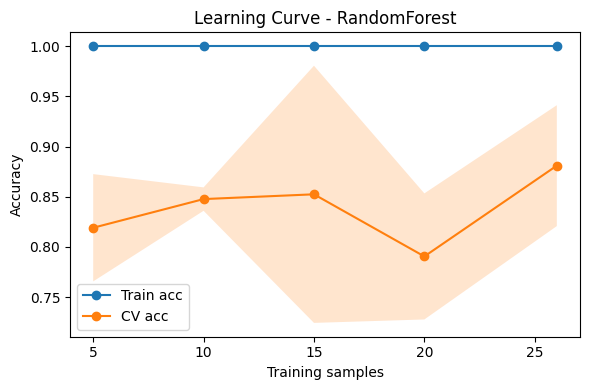

In [46]:
# Learning curve (accuracy vs training size) for best model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

best_name = None
if 'adv_df' in globals() and not adv_df.empty:
    best_name = adv_df.iloc[0]['Model']

def build_estimator(name):
    if name == 'RandomForest' and 'rf' in globals():
        return rf
    if name == 'GradientBoosting':
        return GradientBoostingClassifier(random_state=RANDOM_STATE)
    if name == 'SVM-RBF':
        return Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='rbf', C=2.0, gamma='scale', probability=True, class_weight='balanced', random_state=RANDOM_STATE))
        ])
    try:
        if name == 'XGBoost':
            import xgboost as xgb
            return xgb.XGBClassifier(
                n_estimators=300, max_depth=4, learning_rate=0.05, subsample=0.8,
                colsample_bytree=0.8, eval_metric='mlogloss', random_state=RANDOM_STATE,
                use_label_encoder=False
            )
        if name == 'LightGBM':
            import lightgbm as lgb
            return lgb.LGBMClassifier(n_estimators=400, learning_rate=0.05, num_leaves=31, random_state=RANDOM_STATE)
    except Exception:
        pass
    # Fallback
    return rf if 'rf' in globals() else None

estimator = build_estimator(best_name) if best_name else (rf if 'rf' in globals() else None)
if estimator is None:
    print("No estimator available for learning curve.")
else:
    # Robust CV folds considering smallest class size
    counts = np.bincount(y_train.astype(int)) if y_train.size else np.array([2])
    min_class = int(np.min(counts)) if counts.size else 2
    n_splits = max(2, min(5, min_class))
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    train_sizes = np.linspace(0.2, 1.0, 5)
    sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=cv, n_jobs=None, train_sizes=train_sizes, scoring='accuracy')

    train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
    test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

    plt.figure(figsize=(6,4))
    plt.plot(sizes, train_mean, 'o-', label='Train acc')
    plt.fill_between(sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.plot(sizes, test_mean, 'o-', label='CV acc')
    plt.fill_between(sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
    plt.title(f'Learning Curve - {best_name or "Selected"}')
    plt.xlabel('Training samples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [47]:
# Optional: TensorFlow small dense model
USE_TF = 'tensorflow' in sys.modules
if USE_TF:
    import tensorflow as tf
    from tensorflow.keras import layers, models
    tf.random.set_seed(RANDOM_STATE)
    input_dim = X_feats.shape[1]
    num_classes = len(unique_labels)

    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=0)
    tf_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, tf_pred, target_names=unique_labels))
else:
    print("TensorFlow not installed; skipping TF model.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
              precision    recall  f1-score   support

  flick_left       0.67      1.00      0.80         2
 flick_right       1.00      0.90      0.95        10

    accuracy                           0.92        12
   macro avg       0.83      0.95      0.87        12
weighted avg       0.94      0.92      0.92        12

              precision    recall  f1-score   support

  flick_left       0.67      1.00      0.80         2
 flick_right       1.00      0.90      0.95        10

    accuracy                           0.92        12
   macro avg       0.83      0.95      0.87        12
weighted avg       0.94      0.92      0.92        12



In [48]:
# TFLite int8 export (only if TF model trained)
if USE_TF:
    import tensorflow as tf
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Representative dataset for full int8 quantization
    def representative_dataset_generator():
        for i in range(min(200, X_train.shape[0])):
            yield [X_train[i:i+1].astype(np.float32)]
    converter.representative_dataset = representative_dataset_generator

    # Force int8 quantization for ops and I/O
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model = converter.convert()
    tflite_path = Path("gesture_model_int8.tflite")
    tflite_path.write_bytes(tflite_model)
    print(f"Saved TFLite int8 model: {tflite_path.resolve()}")
else:
    print("Skipping TFLite export (TensorFlow not available).")


INFO:tensorflow:Assets written to: C:\Users\sirad\AppData\Local\Temp\tmp_ykacgmh\assets


INFO:tensorflow:Assets written to: C:\Users\sirad\AppData\Local\Temp\tmp_ykacgmh\assets


Saved artifact at 'C:\Users\sirad\AppData\Local\Temp\tmp_ykacgmh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1293853000096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293830427344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293870712608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293870716480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293870717360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293870717536: TensorSpec(shape=(), dtype=tf.resource, name=None)


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved TFLite int8 model: D:\Code\Arduino\ESP32\ESP32_MPU6050_Air_Mouse\ml\gesture_model_int8.tflite


In [49]:
# Export model artifacts for firmware integration (labels + feature meta + optional C array)
meta = {
    "labels": unique_labels,
    "feature_names": feature_names,
    "window_samples": SAMPLES_PER_WINDOW,
    "overlap": WINDOW_OVERLAP,
    "sampling_hz": EXPECTED_HZ
}
with open("gesture_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)
print("Wrote gesture_meta.json")

# Optional: convert TFLite file into a C array for embedding in firmware
TFLITE_FILENAME = "gesture_model_int8.tflite"
if Path(TFLITE_FILENAME).exists():
    data = Path(TFLITE_FILENAME).read_bytes()
    array_name = "gesture_model_int8"
    header_path = Path("gesture_model_data.h")
    with open(header_path, "w", encoding="utf-8") as h:
        h.write("#pragma once\n#include <cstdint>\n\n")
        h.write(f"// Auto-generated from {TFLITE_FILENAME} ({len(data)} bytes)\n")
        h.write(f"const unsigned int {array_name}_len = {len(data)};\n")
        h.write(f"const unsigned char {array_name}[] = {{\n    ")
        for i, b in enumerate(data):
            h.write(str(b)+', ')
            if (i+1) % 16 == 0:
                h.write("\n    ")
        h.write("\n};\n")
    print(f"Wrote {header_path.resolve()}")
else:
    print("No TFLite model file present; skip C array generation.")


Wrote gesture_meta.json
Wrote D:\Code\Arduino\ESP32\ESP32_MPU6050_Air_Mouse\ml\gesture_model_data.h


In [50]:
# Firmware integration notes (Markdown)
from IPython.display import Markdown, display

display(Markdown(r"""
## Firmware Integration Steps
1. Copy `gesture_model_data.h` into `lib/gesture_model/` (create folder) in PlatformIO project.
2. Include the header where you run inference: `#include "gesture_model_data.h"`.
3. Use TensorFlow Lite for Microcontrollers (add library) and set up a MicroMutableOpResolver with only needed ops (DEPTHWISE_CONV_2D not required for dense-only model).
4. Mirror the feature extraction on-device:
   - Maintain a ring buffer of the last `window_samples` raw readings (ax..gz).
   - Every `STEP` samples, compute the same stats and band energies.
5. Normalize or scale features if you added any normalization during training (none used here beyond raw units).
6. Run inference; map output index to label via `gesture_meta.json` labels order.
7. Threshold low-confidence predictions; optionally require stability over 2–3 consecutive windows.

### Performance Considerations
- RandomForest is NOT embedded; use TF-lite model for MCU.
- Aim for < 30KB flash and < 10KB RAM for model + arena.
- Reduce dense layer sizes if memory is tight (e.g., 32 -> 16 neurons).

### Next Improvements
- Add axis-specific filtering (e.g., 5 Hz low-pass) before feature extraction.
- Evaluate additional features: skewness, kurtosis, gyro band energies.
- Add gesture rejection class ("none") to reduce false positives.
"""))



## Firmware Integration Steps
1. Copy `gesture_model_data.h` into `lib/gesture_model/` (create folder) in PlatformIO project.
2. Include the header where you run inference: `#include "gesture_model_data.h"`.
3. Use TensorFlow Lite for Microcontrollers (add library) and set up a MicroMutableOpResolver with only needed ops (DEPTHWISE_CONV_2D not required for dense-only model).
4. Mirror the feature extraction on-device:
   - Maintain a ring buffer of the last `window_samples` raw readings (ax..gz).
   - Every `STEP` samples, compute the same stats and band energies.
5. Normalize or scale features if you added any normalization during training (none used here beyond raw units).
6. Run inference; map output index to label via `gesture_meta.json` labels order.
7. Threshold low-confidence predictions; optionally require stability over 2–3 consecutive windows.

### Performance Considerations
- RandomForest is NOT embedded; use TF-lite model for MCU.
- Aim for < 30KB flash and < 10KB RAM for model + arena.
- Reduce dense layer sizes if memory is tight (e.g., 32 -> 16 neurons).

### Next Improvements
- Add axis-specific filtering (e.g., 5 Hz low-pass) before feature extraction.
- Evaluate additional features: skewness, kurtosis, gyro band energies.
- Add gesture rejection class ("none") to reduce false positives.


In [51]:
# Raw CSV peek (first 20 lines of the chosen file)
peek_file = None
if PIN_FILENAME:
    for p in found:
        if p.endswith(PIN_FILENAME):
            peek_file = p
            break
else:
    peek_file = found[0] if found else None
print("Peek file:", peek_file)
if peek_file:
    try:
        with open(peek_file, 'r', encoding='utf-8', errors='replace') as fh:
            for i, line in enumerate(fh):
                if i >= 20:
                    break
                print(f"{i+1:02d}: {line.rstrip()}")
    except Exception as e:
        print("Error peeking file:", e)
else:
    print("No file found to peek.")


Peek file: ..\desktop_qt\ml_logs\flick_left_20251109_031457_8d5c3d8d_1.csv
01: timestamp_ms,ax,ay,az,gx,gy,gz,label,segment_id,sample_index
02: 1762636495403,-58,-5,1018,28,4,10,flick_left,8d5c3d8d,0
03: 1762636495428,-64,0,1018,14,10,-3,flick_left,8d5c3d8d,1
04: 1762636495433,-55,-2,1018,8,-15,34,flick_left,8d5c3d8d,2
05: 1762636495530,-64,0,1018,14,10,-3,flick_left,8d5c3d8d,3
06: 1762636495530,-55,-2,1018,8,-15,34,flick_left,8d5c3d8d,4
07: 1762636495559,-61,0,1016,2,8,28,flick_left,8d5c3d8d,5
08: 1762636495634,-61,0,1016,2,8,28,flick_left,8d5c3d8d,6
09: 1762636495685,-60,4,1018,-61,30,-5,flick_left,8d5c3d8d,7
10: 1762636495693,-62,6,1021,-103,11,-29,flick_left,8d5c3d8d,8
11: 1762636495734,-60,4,1018,-61,30,-5,flick_left,8d5c3d8d,9
12: 1762636495734,-62,6,1021,-103,11,-29,flick_left,8d5c3d8d,10
13: 1762636495819,-61,-1,1014,0,2,8,flick_left,8d5c3d8d,11
14: 1762636495829,-64,-4,1016,-2,-21,-2,flick_left,8d5c3d8d,12
15: 1762636495939,-61,-1,1014,0,2,8,flick_left,8d5c3d8d,13
16: 17626364